<a href="https://colab.research.google.com/github/shunzh/llm.ipynb/blob/main/adamw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 AdamW Optimizer from Scratch

In this notebook, we'll implement the **AdamW** optimizer from scratch and test it on a simple MLP trained on synthetic data. AdamW decouples weight decay from the optimization step, leading to better generalization.

## 1. Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 2. Define a Simple Dataset

We'll create a small synthetic regression dataset.

In [ ]:
# Sample x uniformly from -2π to 2π
x = np.random.uniform(-2 * np.pi, 2 * np.pi, size=(500, 1))
y = np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Convert to torch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Wrap in dataset and dataloader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## 3. Define a Simple MLP

A small MLP with a few linear layers and ReLU activations.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

## 4. Implement Adam and AdamW Optimizers

We'll implement the Adam optimizer based on the standard update rule:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\\\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\\\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t},\quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t} \\\\
\theta_{t+1} &= \theta_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

We can regularize the model by applying **L2 penalty** or **decoupled weight decay**.


### L2 Regularization (Used in Classic Adam)

Apply weight decay **inside the gradient** before computing moments:

$$
g_t \leftarrow g_t + \lambda \theta_t
$$

Then continue with the standard Adam updates above.

🔸 This mixes regularization into the gradient, and can interact poorly with Adam’s adaptive updates.

### Decoupled Weight Decay (AdamW)

Apply weight decay **separately from the gradient**, directly on the parameter after all the other steps:

$$
\theta_{t+1} \leftarrow \theta_{t+1} - \eta \cdot \lambda \cdot \theta_t
$$

This keeps the optimization step and regularization **decoupled**, which improves generalization and empirical performance in many settings.

✅ This is the formulation used in `torch.optim.AdamW` and preferred for training deep networks.

In [ ]:
class AdamW:
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        use_l2_norm=False,
        l2_lambda=1e-2,
        use_wd=True,
        weight_decay=1e-2,
    ):
        assert not (use_l2_norm and use_wd), "Use either L2 norm or weight decay, not both."

        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.use_l2_norm = use_l2_norm
        self.l2_lambda = l2_lambda
        self.use_wd = use_wd
        self.weight_decay = weight_decay
        self.t = 0

        self.state = {}
        for p in self.params:
            self.state[p] = {
                'm': torch.zeros_like(p.data),
                'v': torch.zeros_like(p.data),
            }

    def step(self):
        self.t += 1
        for p in self.params:
            if p.grad is None:
                continue

            grad = p.grad.data
            if self.use_l2_norm:
                grad = grad + self.l2_lambda * p.data

            m = self.state[p]['m']
            v = self.state[p]['v']

            # Update biased moments
            m = self.beta1 * m + (1 - self.beta1) * grad
            v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

            # Bias correction
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)

            # Parameter update
            update = m_hat / (v_hat.sqrt() + self.eps)
            p.data = p.data - self.lr * update

            if self.use_wd:
                p.data = p.data - self.lr * self.weight_decay * p.data

            # Save updated m, v
            self.state[p]['m'] = m
            self.state[p]['v'] = v

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

## 5. Training Loop

Train the MLP with AdamW from scratch and track loss.

Training (AdamW Weight Decay): 100%|██████████| 100/100 [00:04<00:00, 23.77it/s]


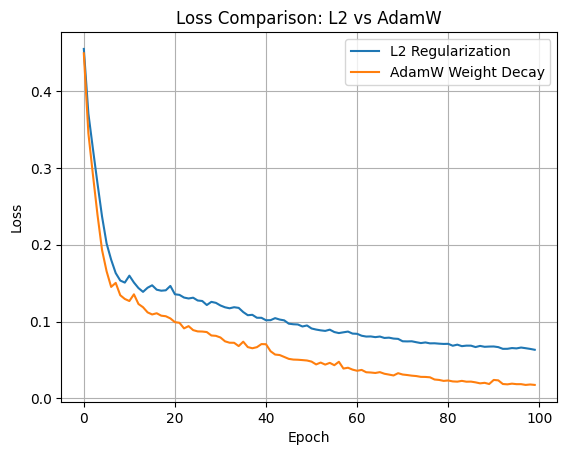

In [ ]:
import matplotlib.pyplot as plt
import copy
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()

# Function to train a model with given optimizer config
def train_model(use_l2_norm=False, use_wd=False, label=""):
    model = MLP().to(device)
    optimizer = AdamW(
        model.parameters(),
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        use_l2_norm=use_l2_norm,
        use_wd=use_wd,
    )

    losses = []

    for epoch in trange(100, desc=f"Training ({label})"):
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch)
            loss = loss_fn(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)

    return losses

# Train with L2 regularization
losses_l2 = train_model(use_l2_norm=True, use_wd=False, label="L2 Regularization")

# Train with decoupled weight decay
losses_wd = train_model(use_l2_norm=False, use_wd=True, label="AdamW Weight Decay")

# Plot
plt.plot(losses_l2, label="L2 Regularization")
plt.plot(losses_wd, label="AdamW Weight Decay")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison: L2 vs AdamW")
plt.legend()
plt.grid(True)
plt.show()